# Load Libraries

In [1]:
import pandas as pd
import numpy as np
import random
import os
import datetime

# 시각화 패키지 불러오기
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# EDA
from ydata_profiling import ProfileReport

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# font
plt.rc('font', family='AppleGothic')

# machine learning
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.ensemble import VotingClassifier

# Fixed Random Seed
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

# Load Dataset

In [2]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

display(train_df.head(3))
display(test_df.head(3))

,ID,Age,Gender,Education_Status,Employment_Status,Working_Week (Yearly),Industry_Status,Occupation_Status,Race,Hispanic_Origin,...,Citizenship,Birth_Country,Birth_Country (Father),Birth_Country (Mother),Tax_Status,Gains,Losses,Dividends,Income_Status,Income
0,TRAIN_00000,63,M,Middle (7-8),Full-Time,4,Social Services,Services,White,All other,...,Native,US,US,US,Nonfiler,0,0,0,Unknown,425
1,TRAIN_00001,37,M,Associates degree (Vocational),Full-Time,52,Entertainment,Services,White,All other,...,Native,US,US,US,Single,0,0,0,Under Median,0
2,TRAIN_00002,58,F,High graduate,Full-Time,52,Manufacturing (Non-durable),Admin Support (include Clerical),Black,All other,...,Native,US,US,US,Married Filling Jointly both under 65 (MFJ),3411,0,0,Under Median,860


,ID,Age,Gender,Education_Status,Employment_Status,Working_Week (Yearly),Industry_Status,Occupation_Status,Race,Hispanic_Origin,...,Household_Summary,Citizenship,Birth_Country,Birth_Country (Father),Birth_Country (Mother),Tax_Status,Gains,Losses,Dividends,Income_Status
0,TEST_0000,79,M,High Junior,Children or Armed Forces,0,Not in universe or children,Unknown,White,All other,...,Householder,Native,US,Unknown,Unknown,Single,0,0,0,Under Median
1,TEST_0001,47,M,Elementary (5-6),Children or Armed Forces,0,Not in universe or children,Unknown,White,Other Spanish,...,Child 18 or older,Native,US,US,US,Nonfiler,0,0,0,Under Median
2,TEST_0002,18,F,High Junior,Children or Armed Forces,52,Retail,Services,White,All other,...,Child 18 or older,Native,US,US,US,Single,0,0,0,Under Median


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   ID                      20000 non-null  object
 1   Age                     20000 non-null  int64 
 2   Gender                  20000 non-null  object
 3   Education_Status        20000 non-null  object
 4   Employment_Status       20000 non-null  object
 5   Working_Week (Yearly)   20000 non-null  int64 
 6   Industry_Status         20000 non-null  object
 7   Occupation_Status       20000 non-null  object
 8   Race                    20000 non-null  object
 9   Hispanic_Origin         20000 non-null  object
 10  Martial_Status          20000 non-null  object
 11  Household_Status        20000 non-null  object
 12  Household_Summary       20000 non-null  object
 13  Citizenship             20000 non-null  object
 14  Birth_Country           20000 non-null  object
 15  Bi

In [4]:
train_df.describe(include='all')

,ID,Age,Gender,Education_Status,Employment_Status,Working_Week (Yearly),Industry_Status,Occupation_Status,Race,Hispanic_Origin,...,Citizenship,Birth_Country,Birth_Country (Father),Birth_Country (Mother),Tax_Status,Gains,Losses,Dividends,Income_Status,Income
count,20000,20000.000000,20000,20000,20000,20000.000000,20000,20000,20000,20000,...,20000,20000,20000,20000,20000,20000.000000,20000.000000,20000.000000,20000,20000.000000
unique,20000,NaN,2,17,8,NaN,24,15,5,10,...,5,43,43,43,6,NaN,NaN,NaN,3,NaN
top,TRAIN_00000,NaN,F,High graduate,Children or Armed Forces,NaN,Not in universe or children,Unknown,White,All other,...,Native,US,US,US,Married Filling Jointly both under 65 (MFJ),NaN,NaN,NaN,Under Median,NaN
freq,1,NaN,10472,6494,11142,NaN,4688,4688,16845,17769,...,17825,17825,16563,16594,8588,NaN,NaN,NaN,13237,NaN
mean,NaN,35.632500,NaN,NaN,NaN,34.943050,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,383.129500,40.202150,123.451450,NaN,554.565250
std,NaN,17.994414,NaN,NaN,NaN,22.254592,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4144.247487,279.182677,1206.949429,NaN,701.553155
min,NaN,0.000000,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,0.000000
25%,NaN,23.000000,NaN,NaN,NaN,7.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,0.000000
50%,NaN,34.000000,NaN,NaN,NaN,52.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,500.000000
75%,NaN,47.000000,NaN,NaN,NaN,52.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,875.000000


In [5]:
# 결측치 확인
train_df.isnull().sum().sum(), test_df.isnull().sum().sum()

(0, 1)

In [6]:
# Pandas Profiling
profile = ProfileReport(train_df, title="Profiling Report")

In [7]:
# profile.to_notebook_iframe()

# EDA 방향성

1. 변수들 간 서로 영향을 강력하게 미치는 것들이 많을 것으로 생각됨. 예를 들어 학력은 job을 구했는지, 일하는 시간 등에 영향을 미칠 것이며, 국가와 인종 관련된 변수도 묶을 수 있을 것이므로, 우선 모델을 돌려보고 변수간 상관관계와 importance를 확인하면서 다중공선성을 제거시켜 나가야 할 듯.
2. 직접적인 영향을 미치는 변수(근로시간, gain, losses, dividens 등)와 간접적인 영향을 미치는 변수(학력, 직업 등) 구분. 가중치를 주면 좋을지?
3. 일단 하나씩 싹 다 보자


# Corr

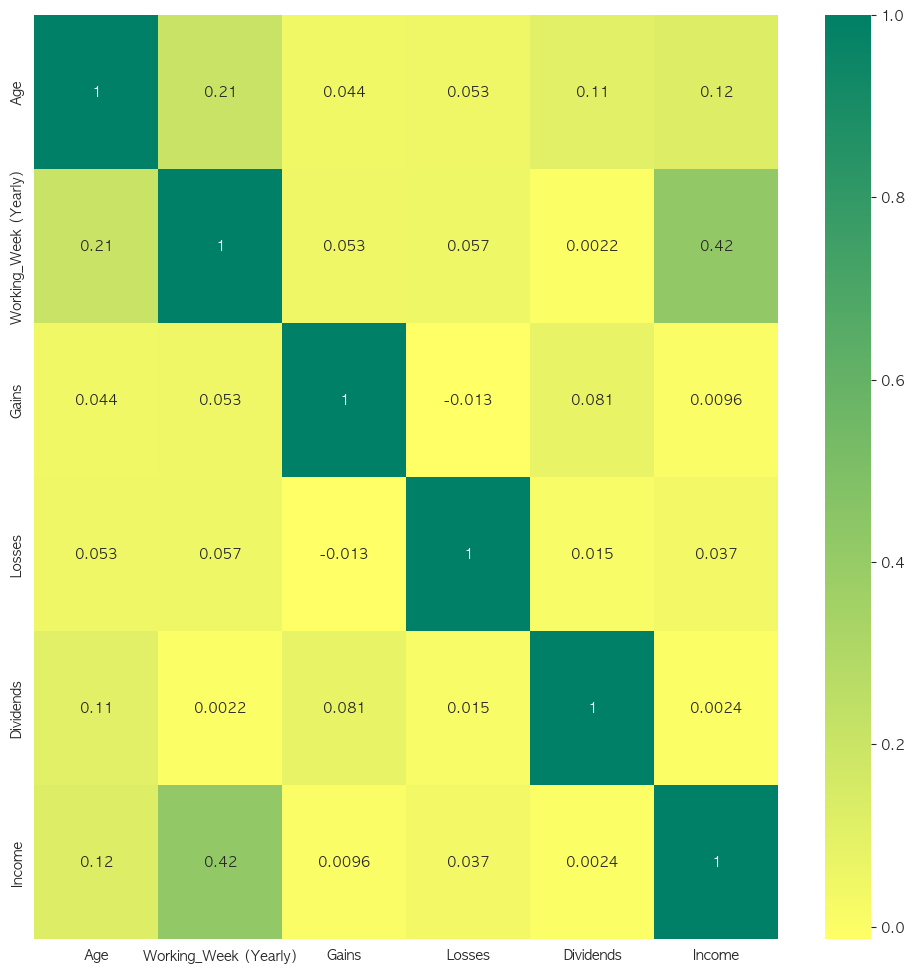

In [8]:
plt.figure(figsize=(12, 12), dpi=100)
sns.heatmap(train_df.corr(), annot=True, cmap="summer_r")
plt.show()

# 변수 분석

In [9]:
train_df.columns

Index(['ID', 'Age', 'Gender', 'Education_Status', 'Employment_Status',
       'Working_Week (Yearly)', 'Industry_Status', 'Occupation_Status', 'Race',
       'Hispanic_Origin', 'Martial_Status', 'Household_Status',
       'Household_Summary', 'Citizenship', 'Birth_Country',
       'Birth_Country (Father)', 'Birth_Country (Mother)', 'Tax_Status',
       'Gains', 'Losses', 'Dividends', 'Income_Status', 'Income'],
      dtype='object')

## Age

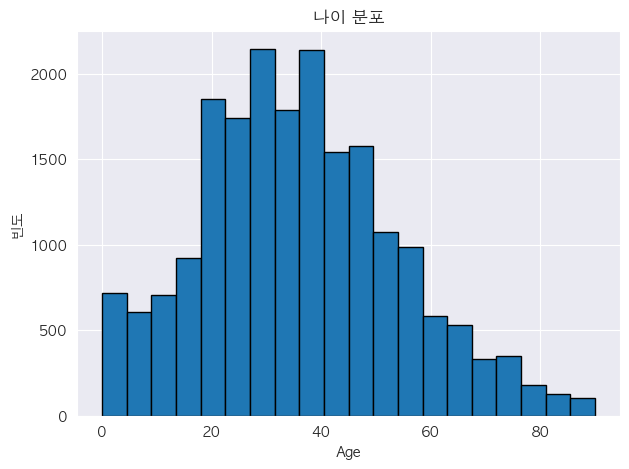

In [14]:
plt.hist(train_df['Age'], bins=20, edgecolor='k')
plt.xlabel('Age')
plt.ylabel('빈도')
plt.title('나이 분포')
plt.show()

In [35]:
## Gender

In [19]:
## Education_Status

Age
(0, 10]       0.000000
(10, 20]    268.672091
(20, 30]    610.282144
(30, 40]    745.315262
(40, 50]    782.834806
(50, 60]    708.134293
(60, 70]    374.214419
(70, 80]    125.550987
(80, 90]     37.676856
Name: Income, dtype: float64

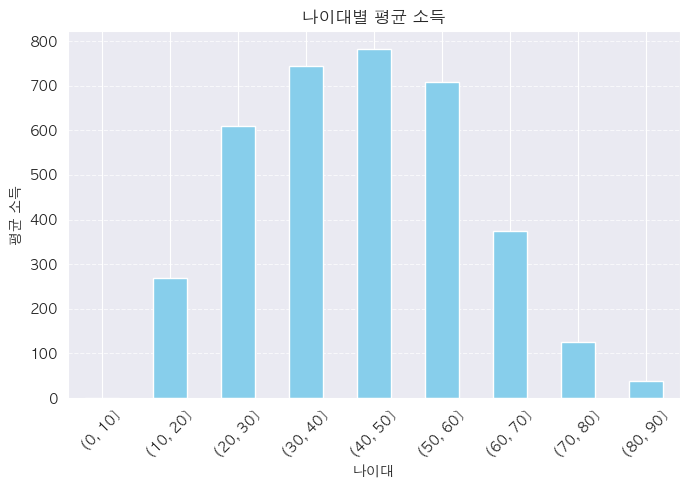

In [27]:
## Employment_Status

In [36]:
## Working_Week (Yearly)

In [21]:
## Industry_Status

In [36]:
## Occupation_Status

In [38]:
## Race

In [38]:
## Hispanic_Origin

In [38]:
## Martial_Status

In [38]:
## Household_Status

In [38]:
## Household_Summary

In [38]:
## Citizenship

In [38]:
## Birth_Country

In [38]:
## Birth_Country (Father) 

In [39]:
## Birth_Country (Mother)

In [39]:
## Tax_Status

In [39]:
## Gains

In [39]:
## Losses

In [40]:
## Dividends

In [40]:
## Income_Status

In [41]:
## Income